In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/Antonio210696/LFWCrop_dataset_pytorch.git "/content/drive/MyDrive/Colab Notebooks/NE240/First Experiment/LFWCrop_dataset_pytorch"
%cd "/content/drive/MyDrive/Colab Notebooks/NE240/First Experiment/LFWCrop_dataset_pytorch"

In [ ]:
import os

In [ ]:
# Prepare to read image pairs
def read_pairs(file_path, label):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return [(line.strip().split()[0], line.strip().split()[1], label) for line in lines]

def load_all_pairs(list_dir):
    all_pairs = []
    for i in range(1, 11):
        prefix = f"{i:02d}"
        for split in ["train", "test"]:
            same_file = os.path.join(list_dir, f"{prefix}_{split}_same.txt")
            diff_file = os.path.join(list_dir, f"{prefix}_{split}_diff.txt")
            all_pairs += read_pairs(same_file, 1)
            all_pairs += read_pairs(diff_file, 0)
    return all_pairs

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch

In [ ]:
class FacePairsDataset(Dataset):
    def __init__(self, pairs, image_dir, transform=None):
        self.pairs = pairs
        self.image_dir = image_dir
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        name1, name2, label = self.pairs[idx]
        name1 += ".ppm"
        name2 += ".ppm"
        img1 = Image.open(os.path.join(self.image_dir, name1)).convert("RGB")
        img2 = Image.open(os.path.join(self.image_dir, name2)).convert("RGB")
        return self.transform(img1), self.transform(img2), torch.tensor(label, dtype=torch.float32)

In [ ]:
data_root = "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch"
face_dir = os.path.join(data_root, "faces")
list_dir = os.path.join(data_root, "lists")
print(face_dir)
print(list_dir)

pairs = load_all_pairs(list_dir)

split_idx = int(0.9 * len(pairs))
train_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]

# Transform --> change pic size!!!!!
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Dataset and DataLoader
train_dataset = FacePairsDataset(train_pairs, face_dir, transform=transform)
val_dataset = FacePairsDataset(val_pairs, face_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch/faces
/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch/lists


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np

In [ ]:
# Embedded Resnet50
class ResNetSiamese(nn.Module):
    def __init__(self, embedding_dim=256):
        super(ResNetSiamese, self).__init__()
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # Kill the FC
        modules = list(base_model.children())[:-1]
        self.backbone = nn.Sequential(*modules)
        self.embedding = nn.Linear(base_model.fc.in_features, embedding_dim)

    def forward_once(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = F.normalize(x, p=2, dim=1)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Using Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = (label) * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Train the model
def train(model, train_loader, val_loader, device, num_epochs=10, lr=1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = ContrastiveLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_train = 0
        total_train = 0

        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            dist = F.pairwise_distance(output1, output2)
            pred = (dist < 0.5).float()
            correct_train += (pred == label).sum().item()
            total_train += label.size(0)

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = correct_train / total_train
        train_accuracies.append(train_acc)

        model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for img1, img2, label in val_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                out1, out2 = model(img1, img2)
                dist = F.pairwise_distance(out1, out2)
                pred = (dist < 0.5).float()
                correct += (pred == label).sum().item()
                total += label.size(0)
                val_loss += criterion(out1, out2, label).item()

        val_acc = correct / total
        val_accuracies.append(val_acc)
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.5f} | Train Acc: {train_acc:.5f} | "
              f"Val Loss: {val_loss:.5f} | Val Acc: {val_acc:.5f}")

# Plot the curves
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig("Loss and Accuracy Curves.png")
    plt.show()


In [ ]:
def show_saliency_top10(model, dataset, device, num_samples=10, threshold_ratio=0.90, save_dir=None):
    model.eval()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for i in range(num_samples):
        img1, _, _ = dataset[i]
        img1 = img1.unsqueeze(0).to(device).requires_grad_()

        out1, _ = model(img1, img1)
        score = out1.norm()
        score.backward()

        saliency, _ = torch.max(img1.grad.data.abs(), dim=1)
        saliency = saliency[0].detach().cpu()

        saliency -= saliency.min()
        saliency /= saliency.max()

        # Show Top 10%
        threshold = torch.quantile(saliency.view(-1), threshold_ratio)
        alpha_mask = torch.where(saliency >= threshold, saliency, torch.tensor(0.0))

        img_np = img1[0].detach().cpu().permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)

        saliency_masked = torch.where(saliency >= threshold, saliency, torch.tensor(0.0))

        alpha_mask = (saliency_masked > 0).float() * 0.6

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(img_np)
        axes[0].set_title("Original")
        axes[0].axis("off")

        axes[1].imshow(img_np)
        axes[1].imshow(saliency_masked, cmap='Reds', alpha=alpha_mask)
        axes[1].set_title("Saliency (Top 10%)")
        axes[1].axis("off")

        plt.tight_layout()

        if save_dir:
            save_path = os.path.join(save_dir, f"saliency_{i}.png")
            plt.savefig(save_path)
            print(f"Saved: {save_path}")

        plt.show()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.2MB/s]


Epoch [1/10] | Train Loss: 0.16363 | Train Acc: 0.81554 | Val Loss: 3.70793 | Val Acc: 0.97017
Epoch [2/10] | Train Loss: 0.03201 | Train Acc: 0.97237 | Val Loss: 1.74368 | Val Acc: 0.97950
Epoch [3/10] | Train Loss: 0.01939 | Train Acc: 0.98050 | Val Loss: 1.13347 | Val Acc: 0.98683
Epoch [4/10] | Train Loss: 0.01320 | Train Acc: 0.98906 | Val Loss: 0.80372 | Val Acc: 0.99267
Epoch [5/10] | Train Loss: 0.00872 | Train Acc: 0.99441 | Val Loss: 0.47864 | Val Acc: 0.99733
Epoch [6/10] | Train Loss: 0.00638 | Train Acc: 0.99689 | Val Loss: 0.32129 | Val Acc: 0.99883
Epoch [7/10] | Train Loss: 0.00496 | Train Acc: 0.99796 | Val Loss: 0.22281 | Val Acc: 0.99917
Epoch [8/10] | Train Loss: 0.00395 | Train Acc: 0.99850 | Val Loss: 0.17128 | Val Acc: 0.99933
Epoch [9/10] | Train Loss: 0.00378 | Train Acc: 0.99804 | Val Loss: 0.13040 | Val Acc: 0.99967
Epoch [10/10] | Train Loss: 0.00301 | Train Acc: 0.99844 | Val Loss: 0.10152 | Val Acc: 0.99983


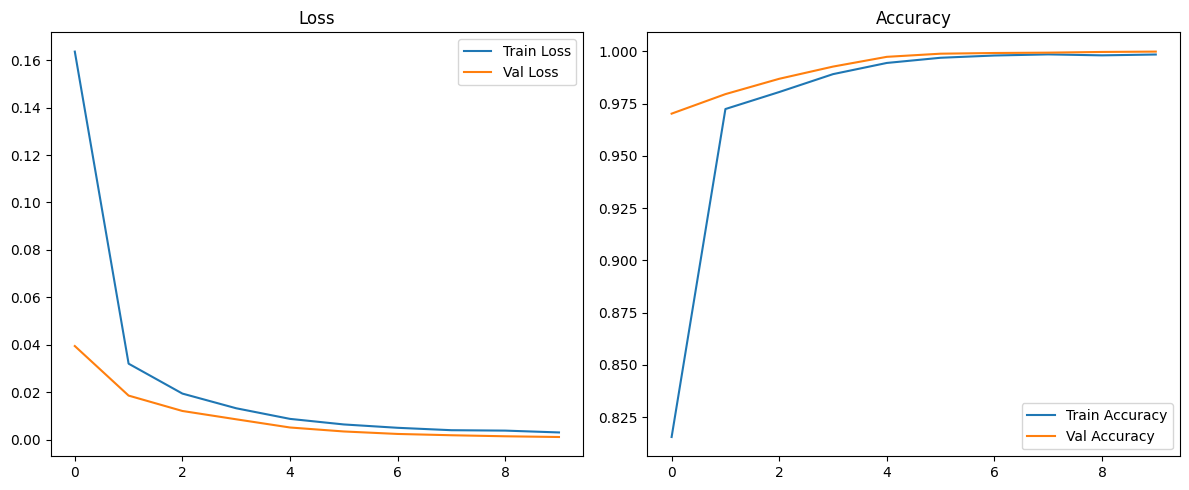

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_0.png


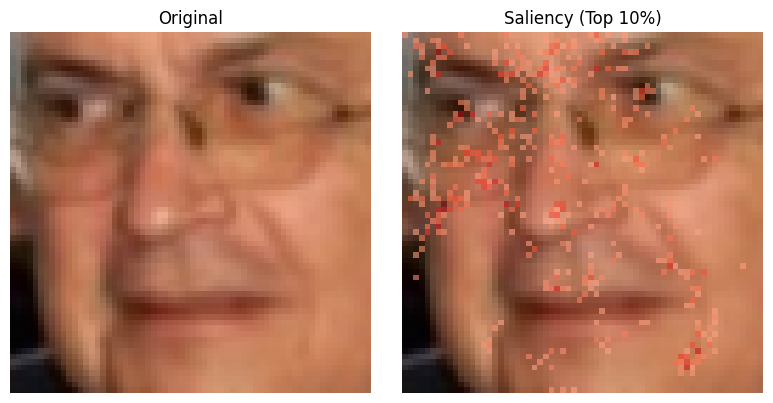

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_1.png


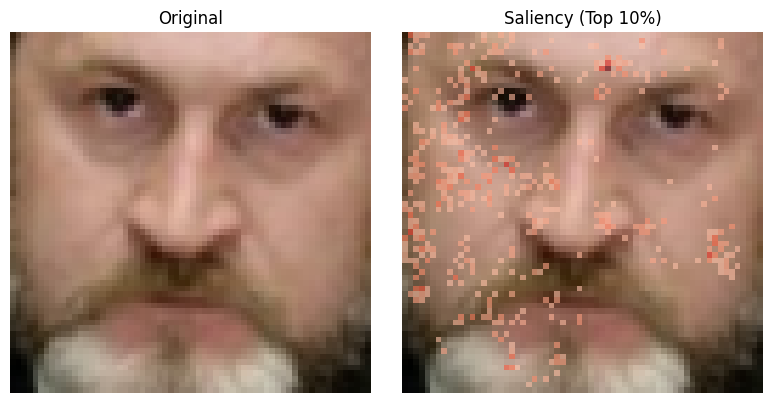

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_2.png


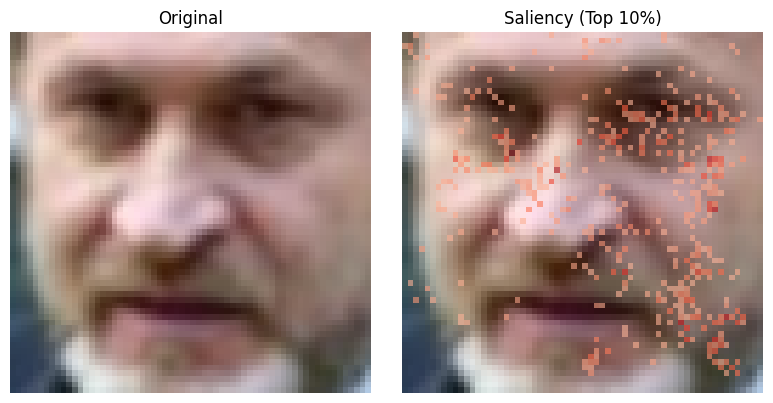

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_3.png


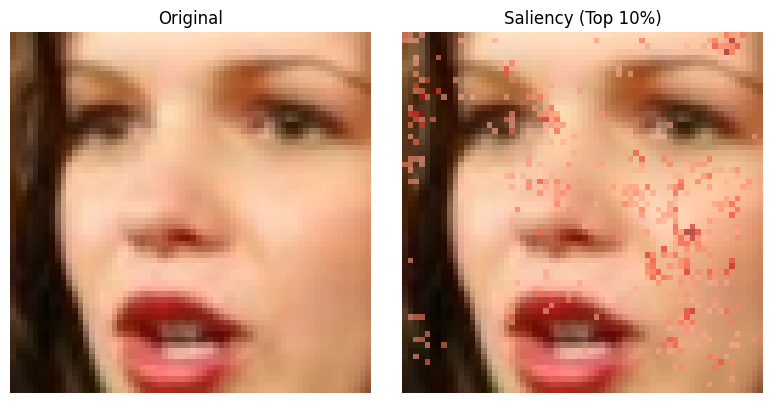

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_4.png


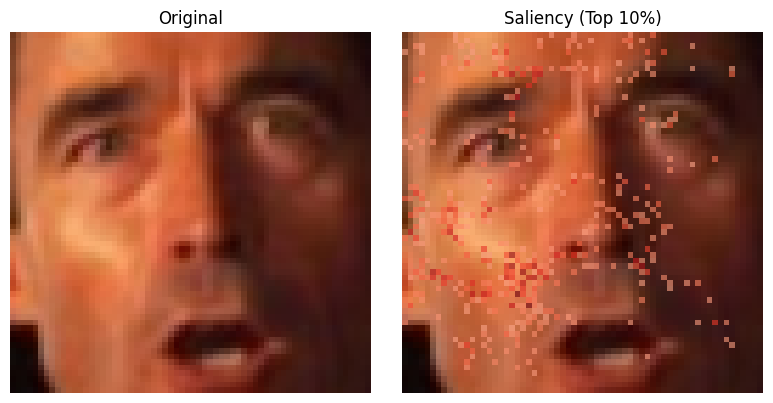

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_5.png


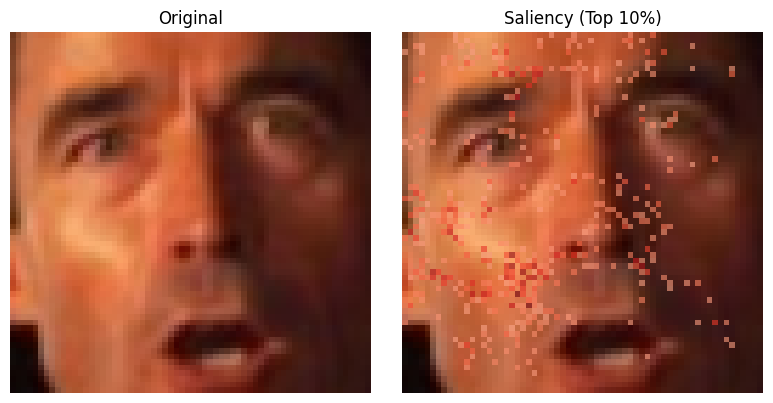

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_6.png


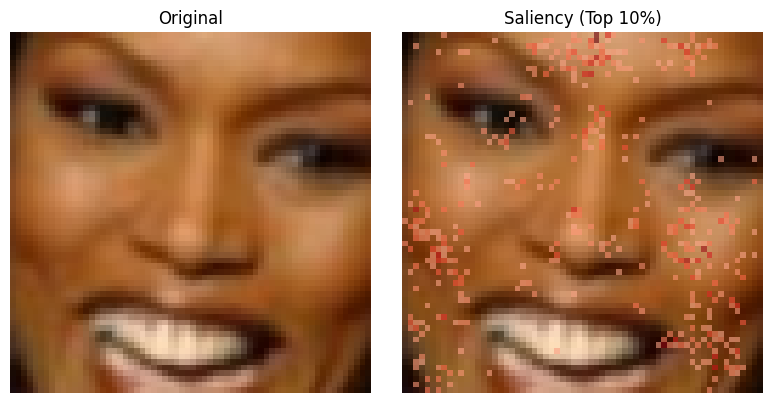

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_7.png


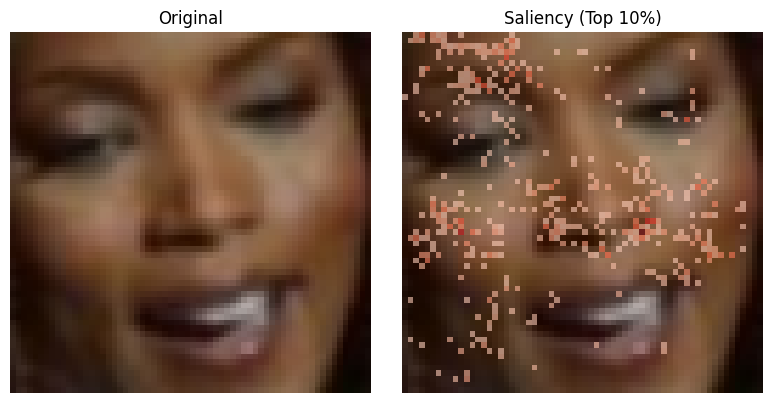

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_8.png


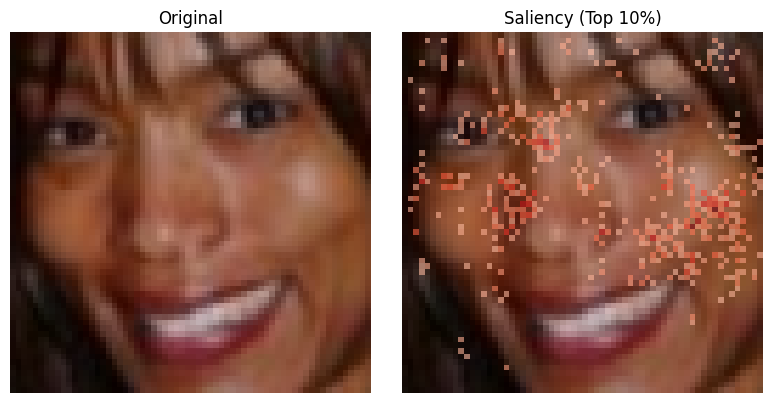

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet/saliency_9.png


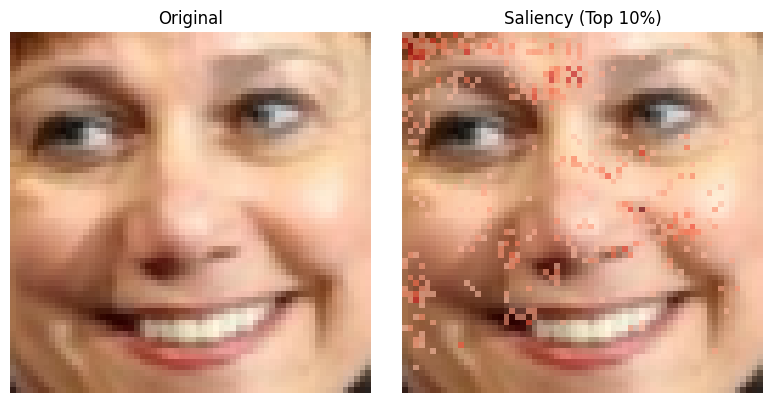

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetSiamese().to(device)
train(model, train_loader, val_loader, device, num_epochs=10)

show_saliency_top10(model, val_dataset, device, num_samples=10, save_dir="/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/ResNet")


Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_0.png


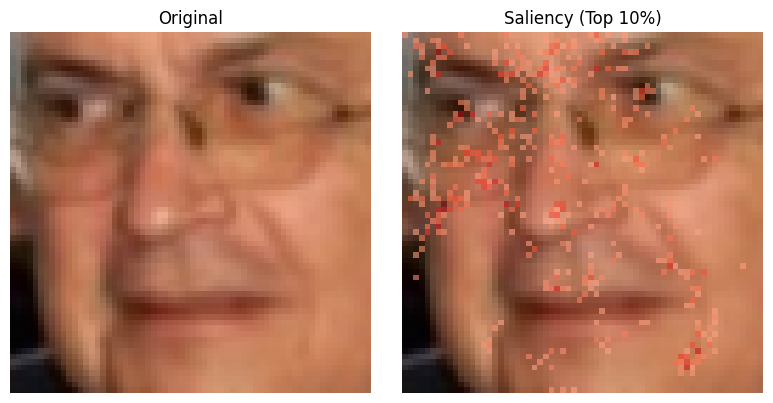

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_1.png


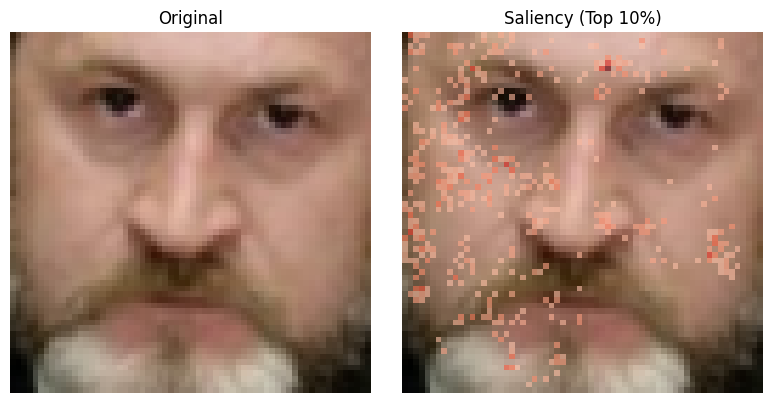

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_2.png


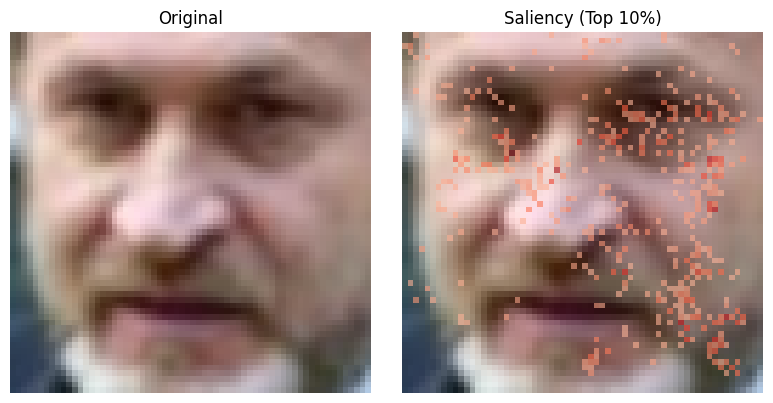

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_3.png


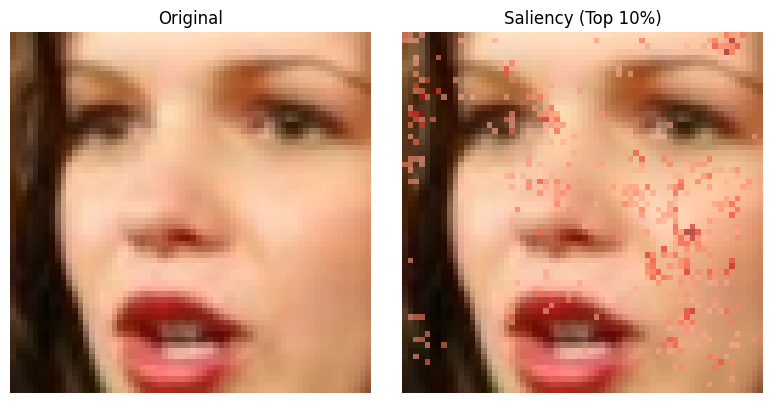

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_4.png


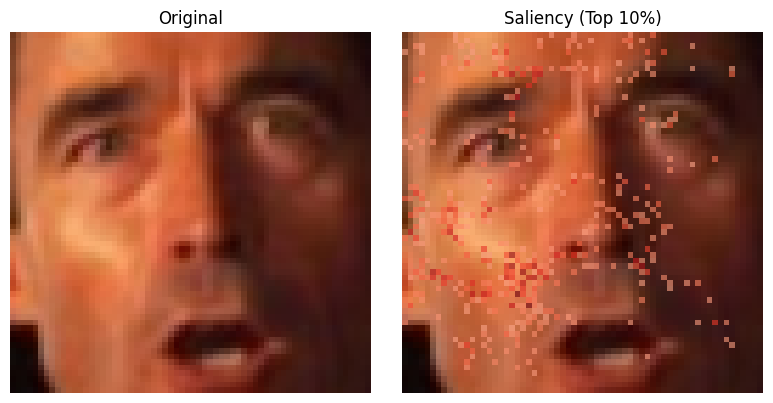

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_5.png


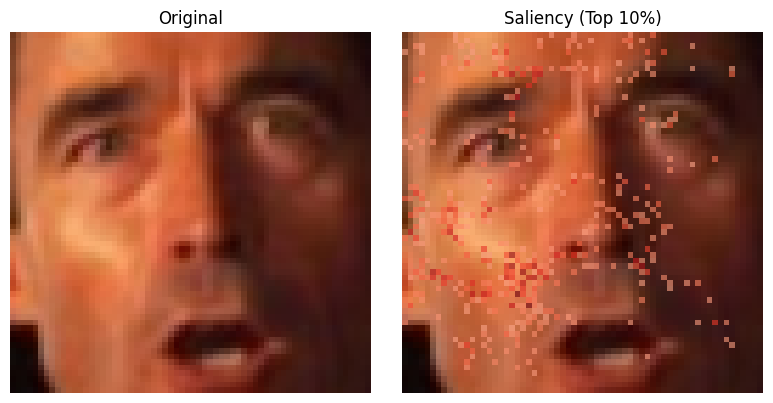

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_6.png


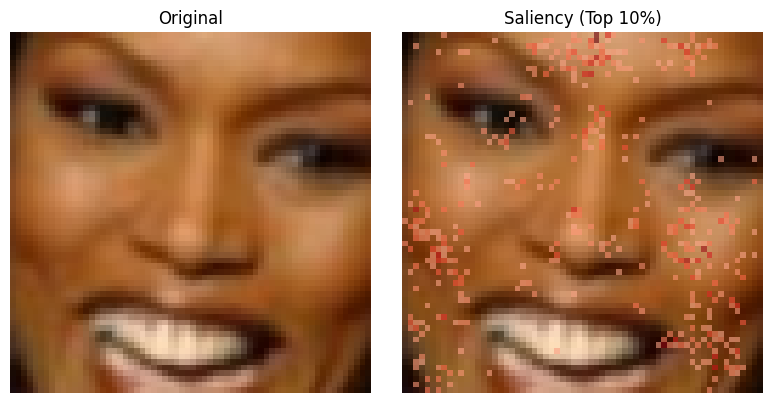

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_7.png


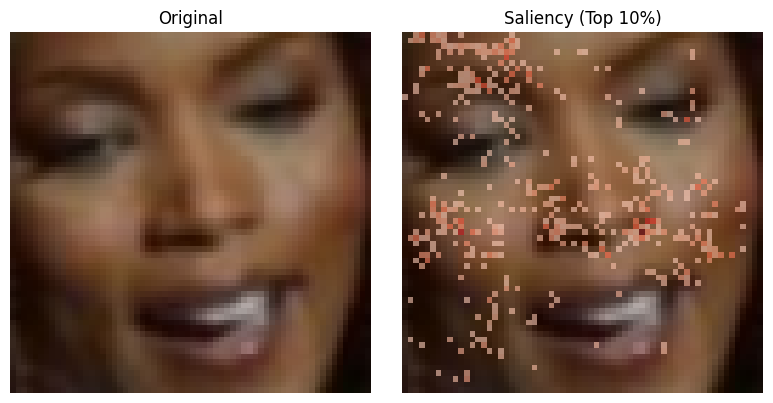

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_8.png


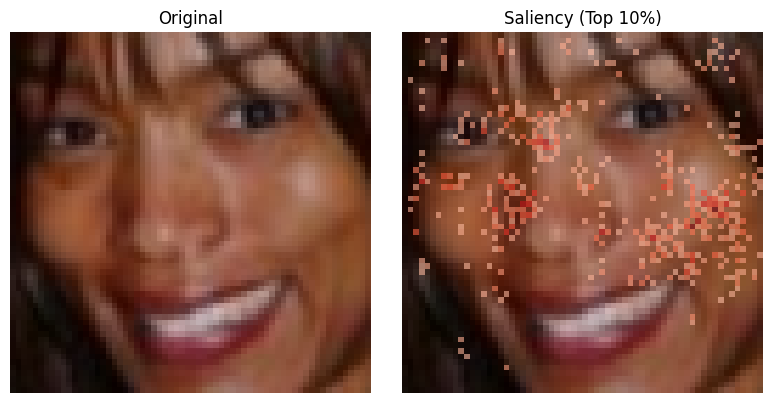

Saved: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/saliency_9.png


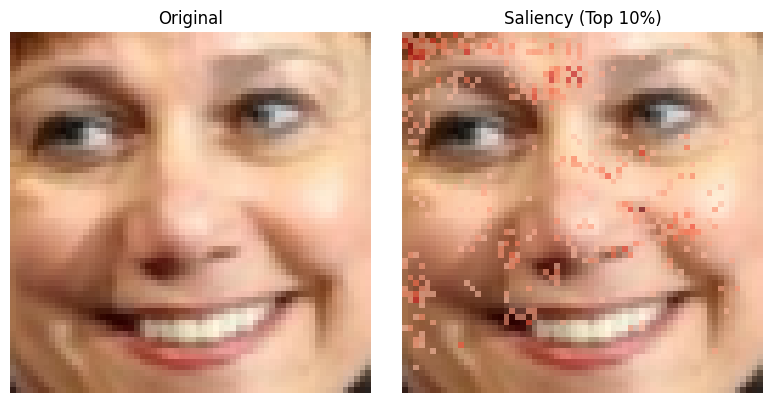

In [ ]:
show_saliency_top10(model, val_dataset, device, num_samples=10, save_dir="/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet")

图表已保存到: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/Loss and Accuracy Curves.png


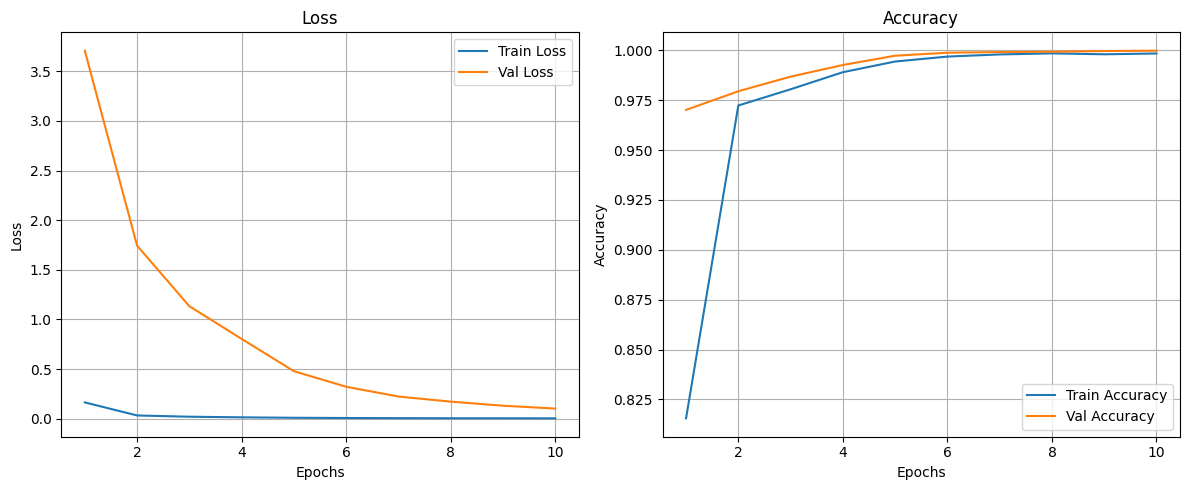

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

save_dir = "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet"
os.makedirs(save_dir, exist_ok=True)

# This is because I forget to save the training data, so I input it by hand
train_losses = [0.16363, 0.03201, 0.01939, 0.01320, 0.00872, 0.00638, 0.00496, 0.00395, 0.00378, 0.00301]
val_losses = [3.70793, 1.74368, 1.13347, 0.80372, 0.47864, 0.32129, 0.22281, 0.17128, 0.13040, 0.10152]
train_accuracies = [0.81554, 0.97237, 0.98050, 0.98906, 0.99441, 0.99689, 0.99796, 0.99850, 0.99804, 0.99844]
val_accuracies = [0.97017, 0.97950, 0.98683, 0.99267, 0.99733, 0.99883, 0.99917, 0.99933, 0.99967, 0.99983]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses,  label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies,  label='Train Accuracy')
plt.plot(range(1, 11), val_accuracies,  label='Val Accuracy')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
save_path = os.path.join(save_dir, "Loss and Accuracy Curves.png")
plt.savefig(save_path, dpi=300)
print(f"图表已保存到: {save_path}")

plt.show()

#Temporary Try

Epoch [1/10] | Train Loss: 0.16400 | Train Acc: 0.80859 | Val Loss: 3.57692 | Val Acc: 0.97117

Epoch [2/10] | Train Loss: 0.03239 | Train Acc: 0.97180 | Val Loss: 1.75516 | Val Acc: 0.97817

Epoch [3/10] | Train Loss: 0.02035 | Train Acc: 0.97859 | Val Loss: 1.32071 | Val Acc: 0.98350

Epoch [4/10] | Train Loss: 0.01481 | Train Acc: 0.98583 | Val Loss: 0.95792 | Val Acc: 0.99183

Epoch [5/10] | Train Loss: 0.01077 | Train Acc: 0.99106 | Val Loss: 0.61136 | Val Acc: 0.99617

Epoch [6/10] | Train Loss: 0.00738 | Train Acc: 0.99591 | Val Loss: 0.40969 | Val Acc: 0.99867

Epoch [7/10] | Train Loss: 0.00527 | Train Acc: 0.99815 | Val Loss: 0.26804 | Val Acc: 0.99900

Epoch [8/10] | Train Loss: 0.00448 | Train Acc: 0.99820 | Val Loss: 0.24671 | Val Acc: 0.99833

Epoch [9/10] | Train Loss: 0.00389 | Train Acc: 0.99850 | Val Loss: 0.19682 | Val Acc: 0.99950

Epoch [10/10] | Train Loss: 0.00323 | Train Acc: 0.99854 | Val Loss: 0.11711 | Val Acc: 1.00000


In [ ]:
# Calculate the prediction
def predict(model, img_path1, img_path2, device, transform=None, threshold=0.5, alpha=10, beta=5):
    model.eval()

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    img1 = Image.open(img_path1).convert("RGB")
    img2 = Image.open(img_path2).convert("RGB")

    img1_tensor = transform(img1).unsqueeze(0).to(device)
    img2_tensor = transform(img2).unsqueeze(0).to(device)

    with torch.no_grad():
        out1, out2 = model(img1_tensor, img2_tensor)
        distance = F.pairwise_distance(out1, out2).item()

    confidence = torch.sigmoid(torch.tensor(-alpha * distance + beta)).item()

    same = distance < threshold
    print(f"Eculidean Distance: {distance:.4f}")
    print(f"Prediction: {confidence * 100:.2f}%")
    print(f"{'Same persom' if same else 'Different Person'}")

    return same, distance, confidence


In [ ]:
predict(model, "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test_n.jpg", device, transform=None, threshold=0.5, alpha=10, beta=5)

Eculidean Distance: 0.0629
Prediction: 98.75%
Same persom


(True, 0.06289253383874893, 0.9875200986862183)

In [ ]:
same, dist, prob = predict(model, "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test_n.jpg", device, transform=None, threshold=0.5, alpha=10, beta=5)

fig, ax1 = plt.subplots(figsize=(8, 5))

width = 0.3
bar_positions = [0.3, 0.7]

ax1.bar(bar_positions[0], dist, width, color='blue', label='Distance')
ax1.set_ylabel('Distance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

y_limit = 0.5
ax1.set_ylim(0, y_limit)

ax1.set_xticks(bar_positions)
ax1.set_xticklabels(['Distance', 'Probability'])

ax1.text(bar_positions[0], dist + y_limit * 0.02, f"{dist:.4f}", ha='center', va='bottom', color='blue')

ax2 = ax1.twinx()
ax2.bar(bar_positions[1], prob*100, width, color='orange', label='Probability')
ax2.set_ylabel('Similarity (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 110)

ax2.text(bar_positions[1], prob*100 + 3, f"{prob*100:.4f}%", ha='center', va='bottom', color='orange')

plt.title('ResNet50 Model Prediction of Thatcher Illusion')
plt.tight_layout()

if os.path.exists("/content/drive"):
    save_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet", "predictions")
else:
    save_dir = os.path.join(os.getcwd(), "output_images", "HED", "predictions")

os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, f"resnet_prediction_Thatcher.png")
plt.savefig(save_path, dpi=300)
print(f"Saved prediction → {save_path}")

plt.show()

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.ResNetSiamese was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ResNetSiamese])` or the `torch.serialization.safe_globals([ResNetSiamese])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

Eculidean Distance: 0.0394
Prediction: 99.01%
Same persom
Saved prediction → /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/predictions/resnet_prediction_PartandWhole.png


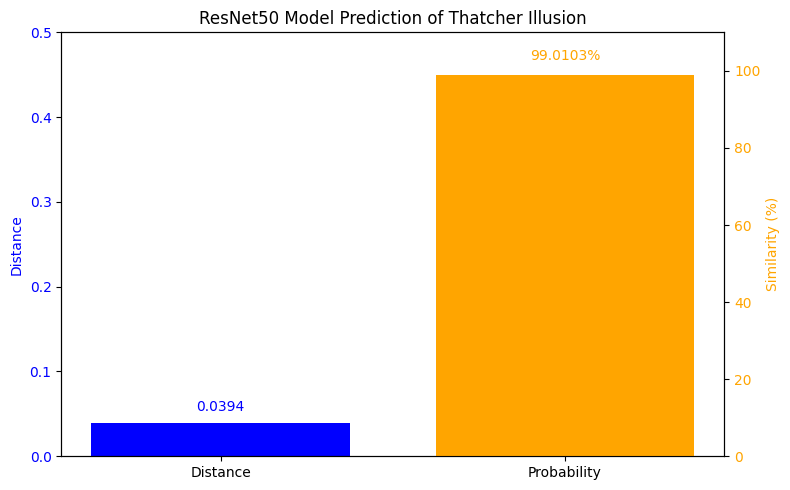

In [ ]:
same, dist, prob = predict(model, "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion_n.jpg", device, transform=None, threshold=0.5, alpha=10, beta=5)

fig, ax1 = plt.subplots(figsize=(8, 5))

width = 0.3
bar_positions = [0.3, 0.7]

ax1.bar(bar_positions[0], dist, width, color='blue', label='Distance')
ax1.set_ylabel('Distance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

y_limit = 0.5
ax1.set_ylim(0, y_limit)

ax1.set_xticks(bar_positions)
ax1.set_xticklabels(['Distance', 'Probability'])

ax1.text(bar_positions[0], dist + y_limit * 0.02, f"{dist:.4f}", ha='center', va='bottom', color='blue')

ax2 = ax1.twinx()
ax2.bar(bar_positions[1], prob*100, width, color='orange', label='Probability')
ax2.set_ylabel('Similarity (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 110)

ax2.text(bar_positions[1], prob*100 + 3, f"{prob*100:.4f}%", ha='center', va='bottom', color='orange')

plt.title('ResNet50 Model Prediction of Thatcher Illusion')
plt.tight_layout()

if os.path.exists("/content/drive"):
    save_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet", "predictions")
else:
    save_dir = os.path.join(os.getcwd(), "output_images", "HED", "predictions")

os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, f"resnet_prediction_PartandWhole.png")
plt.savefig(save_path, dpi=300)
print(f"Saved prediction → {save_path}")

plt.show()

Eculidean Distance: 0.0954
Prediction: 98.28%
Same persom
Saved prediction → /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/predictions/resnet_prediction_PartandWhole2.png


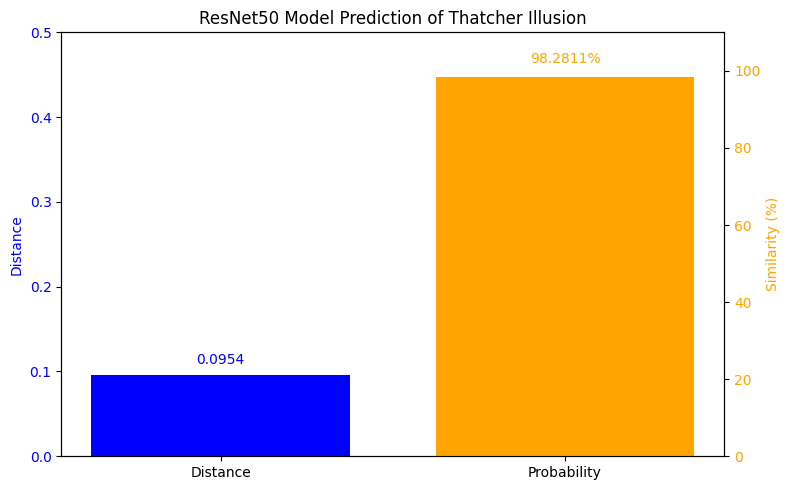

In [ ]:
same, dist, prob = predict(model, "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion2.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion_n2.jpg", device, transform=None, threshold=0.5, alpha=10, beta=5)
fig, ax1 = plt.subplots(figsize=(8, 5))

width = 0.3
bar_positions = [0.3, 0.7]

ax1.bar(bar_positions[0], dist, width, color='blue', label='Distance')
ax1.set_ylabel('Distance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

y_limit = 0.5
ax1.set_ylim(0, y_limit)

ax1.set_xticks(bar_positions)
ax1.set_xticklabels(['Distance', 'Probability'])

ax1.text(bar_positions[0], dist + y_limit * 0.02, f"{dist:.4f}", ha='center', va='bottom', color='blue')

ax2 = ax1.twinx()
ax2.bar(bar_positions[1], prob*100, width, color='orange', label='Probability')
ax2.set_ylabel('Similarity (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 110)

ax2.text(bar_positions[1], prob*100 + 3, f"{prob*100:.4f}%", ha='center', va='bottom', color='orange')

plt.title('ResNet50 Model Prediction of Thatcher Illusion')
plt.tight_layout()

if os.path.exists("/content/drive"):
    save_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet", "predictions")
else:
    save_dir = os.path.join(os.getcwd(), "output_images", "HED", "predictions")

os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, f"resnet_prediction_PartandWhole2.png")
plt.savefig(save_path, dpi=300)
print(f"Saved prediction → {save_path}")

plt.show()

Eculidean Distance: 0.0509
Prediction: 98.89%
Same persom
Saved prediction → /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/predictions/resnet_prediction_Thatcher2.png


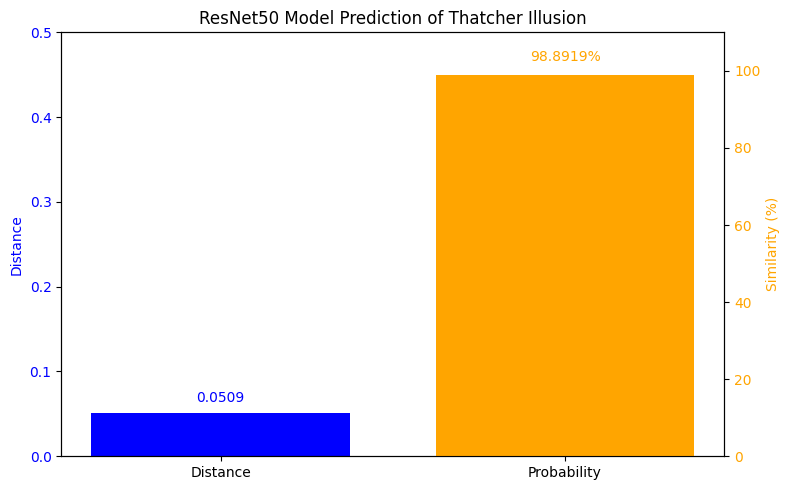

In [ ]:
same, dist, prob = predict(model, "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test2.jpg", "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test_n2.jpg", device, transform=None, threshold=0.5, alpha=10, beta=5)

fig, ax1 = plt.subplots(figsize=(8, 5))

width = 0.3
bar_positions = [0.3, 0.7]

ax1.bar(bar_positions[0], dist, width, color='blue', label='Distance')
ax1.set_ylabel('Distance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

y_limit = 0.5
ax1.set_ylim(0, y_limit)

ax1.set_xticks(bar_positions)
ax1.set_xticklabels(['Distance', 'Probability'])

ax1.text(bar_positions[0], dist + y_limit * 0.02, f"{dist:.4f}", ha='center', va='bottom', color='blue')

ax2 = ax1.twinx()
ax2.bar(bar_positions[1], prob*100, width, color='orange', label='Probability')
ax2.set_ylabel('Similarity (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 110)

ax2.text(bar_positions[1], prob*100 + 3, f"{prob*100:.4f}%", ha='center', va='bottom', color='orange')

plt.title('ResNet50 Model Prediction of Thatcher Illusion')
plt.tight_layout()

if os.path.exists("/content/drive"):
    save_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet", "predictions")
else:
    save_dir = os.path.join(os.getcwd(), "output_images", "HED", "predictions")

os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, f"resnet_prediction_Thatcher2.png")
plt.savefig(save_path, dpi=300)
print(f"Saved prediction → {save_path}")

plt.show()

In [ ]:
# This is to save the model
import os
import torch
from datetime import datetime

model_name = "ResNet50"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/{model_name}_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "model.pt")
torch.save(model, model_path)

weights_path = os.path.join(save_dir, "weights.pt")
torch.save(model.state_dict(), weights_path)

config = {
    "model_name": model_name,
    "input_size": [3, 224, 224],
    "output_size": model.output_size if hasattr(model, "output_size") else None,
    "timestamp": timestamp,
    "description": "HED model trained on face recognition task"
}

import json
with open(os.path.join(save_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

print(f"模型已保存到目录: {save_dir}")

模型已保存到目录: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/ResNet/ResNet50_20250505_044227


In [ ]:
# This is to calculate the size of model and # of parameters
def count_parameters(model):

    total_params = sum(p.numel() for p in model.parameters())

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f'总参数数量: {total_params:,}')
    print(f'可训练参数数量: {trainable_params:,}')
    print(f'固定参数数量: {total_params - trainable_params:,}')
    print(f'参数内存占用 (MB): {total_params * 4 / (1024 * 1024):.2f}')

    return total_params, trainable_params

total, trainable = count_parameters(model)

with open(f'{save_dir}/model_parameters.txt', 'w') as f:
    f.write(f'总参数数量: {total:,}\n')
    f.write(f'可训练参数数量: {trainable:,}\n')
    f.write(f'固定参数数量: {total - trainable:,}\n')
    f.write(f'参数内存占用 (MB): {total * 4 / (1024 * 1024):.2f}\n')

print('参数信息已保存到 model_parameters.txt')

总参数数量: 24,032,576
可训练参数数量: 24,032,576
固定参数数量: 0
参数内存占用 (MB): 91.68
参数信息已保存到 model_parameters.txt
